# Generate events by sampling uniformly

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from exp_analysis import *
from exp_analysis.exp_analysis import *

In [46]:
from exp_analysis.parameters_dict import physics_parameters

In [47]:
physics_parameters

{'heavy': {'m4_limits': (0.005, 1),
  'mz_limits': (0.005, 10),
  'm4_scan': [0.01, 0.1, 0.5],
  'mz_scan': [0.01, 0.1, 1, 5],
  'alpha_dark': 0.4,
  'Umu4': 2.2e-07,
  'epsilon2': 0.00046,
  'alpha_em': 0.0072992700729927005,
  'span_2d': 9.945025,
  'Vmu4_alpha_epsilon2': 2.9547445255474454e-13}}

In [48]:
from dark_news import *

In [49]:
import numpy as np
from matplotlib import pyplot as plt

In [50]:
case = 'heavy'
save_folder = f'./data/nd280_nu/3plus1/uniform_scan/{case}_mediator/'

In [103]:
BSMparams = model.model_params()
     
BSMparams.gprime = np.sqrt(4*np.pi*physics_parameters[case]['alpha_dark'])
BSMparams.chi = np.sqrt(physics_parameters[case]['epsilon2'])/const.cw
BSMparams.Ue4 = 0.0
BSMparams.Umu4 = np.sqrt(physics_parameters[case]['Umu4'])
BSMparams.Utau4 = 0
BSMparams.Ue5 = 0.0
BSMparams.Umu5 = np.sqrt(26.5e-8)
BSMparams.Utau5 = 0
BSMparams.Ue6 = 0.0
BSMparams.Umu6 = np.sqrt(123.0e-8*0.0629)
BSMparams.Utau6 = 0
BSMparams.UD4 = 1
BSMparams.UD5 = 0
BSMparams.UD6 = 0
BSMparams.m4 = 0.100
BSMparams.m5 = 1e6
BSMparams.m6 = 1e6
BSMparams.Mzprime = 0.03
BSMparams.Dirac = 0

BSMparams.M4_min = physics_parameters[case]['m4_limits'][0]
BSMparams.M4_max = physics_parameters[case]['m4_limits'][1]

BSMparams.mzprime_min = physics_parameters[case]['mz_limits'][0]
BSMparams.mzprime_max = physics_parameters[case]['mz_limits'][1]

BSMparams.set_high_level_variables()

BSMparams.hierarchy = f'{case}_mediator'
BSMparams.scan = True
BSMparams.number_of_scanned_params = 2

myexp = exp.experiment("nd280_nu")

In [104]:
this_MC = MC.MC_events(
                    BSMparams, 
                    myexp, 
                    datafile=None, 
                    MA=1*const.MAVG, 
                    Z=82, 
                    nu_scatterer=pdg.numu,
                    nu_produced=pdg.neutrino4, 
                    nu_outgoing=pdg.numu, 
                    final_lepton=pdg.electron,
                    h_upscattered=-1)

In [105]:
if case == 'heavy':
    DIM = 6
    if BSMparams.scan:
        DIM += BSMparams.number_of_scanned_params

    batch_f = integrands.threebody(dim=DIM, Emin=this_MC.EMIN, Emax=this_MC.EMAX, MC_case=this_MC)

In [106]:
rng = np.random.default_rng()

In [107]:
nsamples = 1000000
random_uniform_numbers = rng.uniform(0, 1, [nsamples, DIM])

In [108]:
weights = batch_f.__call__(random_uniform_numbers)

In [109]:
out = integrands.three_body_phase_space(samples=random_uniform_numbers.T, MC_case=this_MC)

In [110]:
out['m4'] = out['m4_scan']
out['mzprime'] = out['mzprime_scan']

In [111]:
weights['decay rate N'] = (weights['decay rate N'] / (out['mzprime']**4 * nsamples))

Text(0.5, 1.0, 'Points randomly generated with the threebody integral function')

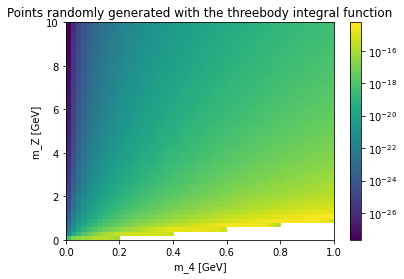

In [112]:
from matplotlib.colors import LogNorm
ranges = [[0,1], [0,10]]
bins = (50, 50)
bin_size = (ranges[0][1]-ranges[0][0]) * (ranges[1][1]-ranges[1][0]) / (bins[0]*bins[1])
plt.hist2d(out['m4'], out['mzprime'], bins=bins, range=ranges,
           weights=weights['decay rate N'] / bin_size, norm=LogNorm())
plt.colorbar()
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.xlabel('m_4 [GeV]')
plt.ylabel('m_Z [GeV]')
plt.title('Points randomly generated with the threebody integral function')

Text(0.5, 1.0, 'Restricting to m_Z > 1 GeV')

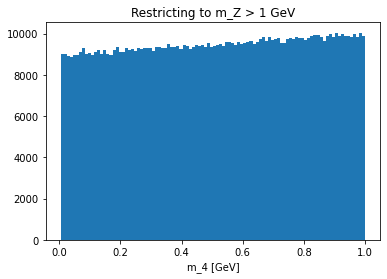

In [113]:
mask = out['mzprime_scan'] > 1
plt.hist(out['m4_scan'][mask], bins=100)
plt.xlabel('m_4 [GeV]')
plt.title('Restricting to m_Z > 1 GeV')

# Compare sum of the weights with the analytic function

In [114]:
# def gamma_heavy(m4, mz, Valpha4_alphaepsilon2):
#     return Valpha4_alphaepsilon2/(24 * np.pi) * m4**5/mz**4

# def gamma_heavy_integrated(m4_s, mz_s, Valpha4_alphaepsilon2, normalised=True):
#     aux = Valpha4_alphaepsilon2/(24 * np.pi) * (1/6) * (1/(-3))
#     aux *= (m4_s[1]**6 - m4_s[0]**6)
#     aux *= (mz_s[1]**(-3) - mz_s[0]**(-3))
#     if normalised:
#         aux /= ((m4_s[1] - m4_s[0])*(mz_s[1] - mz_s[0]))
#     return aux

In [120]:
def output_distrib(df, weights, binning_in, bins, hist_range, range_other_variable, type_of_truth):  
    values_hist = df[binning_in]
    hist_mask = (values_hist > hist_range[0]) &\
                (values_hist < hist_range[1])
    if binning_in == 'm4':
        other_variable = 'mzprime'
    elif binning_in == 'mzprime':
        other_variable = 'm4'
    other_variable_mask = (df[other_variable] > range_other_variable[0]) &\
                          (df[other_variable] < range_other_variable[1])
    total_mask = hist_mask & other_variable_mask
    bin_size = (hist_range[1] - hist_range[0])/bins * (range_other_variable[1] - range_other_variable[0])
    
    bin_edges = np.linspace(*hist_range, bins+1)
    hist_out = plt.hist(values_hist[total_mask],
             bins=bin_edges,
             weights=weights[total_mask]/bin_size,
             histtype='step',
             label=f'{range_other_variable[0]:.2g} < {other_variable} < {range_other_variable[1]:.2g}')
    plt.xlabel(binning_in)
    plt.ylabel('Decay rate [GeV]')
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    if type_of_truth == 'function':
        mid_other_variable = (range_other_variable[1] + range_other_variable[0])/2
        if binning_in == 'm4':
            aux_truth = gamma_heavy(bin_centers, mid_other_variable, physics_parameters[case]['Vmu4_alpha_epsilon2'])
        elif binning_in == 'mzprime':
            aux_truth = gamma_heavy(mid_other_variable, bin_centers, physics_parameters[case]['Vmu4_alpha_epsilon2'])
    elif type_of_truth == 'average':
        aux_truth = []
        for aux_bin_edges in zip(bin_edges[:-1], bin_edges[1:]):
            if binning_in == 'm4':
                aux_truth.append(gamma_heavy_integrated(aux_bin_edges, 
                                                        range_other_variable, 
                                                        physics_parameters[case]['Vmu4_alpha_epsilon2'], 
                                                        normalised=True))
            elif binning_in == 'mzprime':
                aux_truth.append(gamma_heavy_integrated(range_other_variable, 
                                                        aux_bin_edges, 
                                                        physics_parameters[case]['Vmu4_alpha_epsilon2'], 
                                                        normalised=True))
    aux_truth = np.array(aux_truth)
    print(f'bin size = {bin_size:.2g}')
    print(f'histogram_entries = {total_mask.sum():.2g}')
#     print(f'Total integral from vegas = {weights[total_mask].sum():.2g}')
    print(f'histogram integral = {hist_out[0].sum():.2g}')
    print(f'Truth = {aux_truth.sum():.2g}')
    print(f'Ratio = {(aux_truth.sum()/hist_out[0].sum()):.2g}')
    plt.plot(bin_centers,
            aux_truth,
            '.',
            label=f'truth {type_of_truth}')
    plt.yscale('log')
    plt.legend(loc='best', frameon=False)

bin size = 0.1
histogram_entries = 9.2e+04
histogram integral = 1.4e-19
Truth = 1.4e-19
Ratio = 0.98


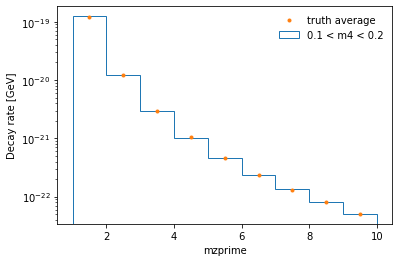

In [121]:
# normal call
output_distrib(df=out, 
               weights=weights['decay rate N'],
               binning_in='mzprime', #m4 or mzprime
               bins=9, 
               hist_range=[1, 10], 
               range_other_variable=[0.1, 0.2], 
               type_of_truth='average')

bin size = 0.1
histogram_entries = 9.2e+04
histogram integral = 1.4e-19
Truth = 1.4e-19
Ratio = 0.98


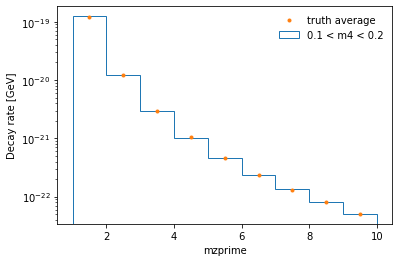

In [123]:
# normal call
output_distrib(df=out, 
               weights=weights['decay rate N'],
               binning_in='mzprime', #m4 or mzprime
               bins=9, 
               hist_range=[1, 10], 
               range_other_variable=[0.1, 0.2], 
               type_of_truth='average')

bin size = 0.1
histogram_entries = 9.9e+04
histogram integral = 8.5e-16
Truth = 8.4e-16
Ratio = 0.99


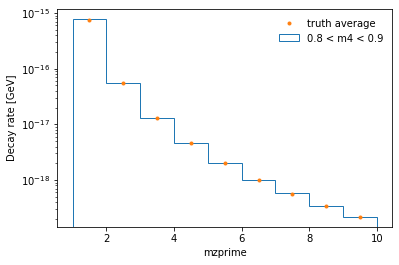

In [124]:
# normal call
output_distrib(df=out, 
               weights=weights['decay rate N'],
               binning_in='mzprime', #m4 or mzprime
               bins=9, 
               hist_range=[1, 10], 
               range_other_variable=[0.8, 0.9], 
               type_of_truth='average')

bin size = 0.1
histogram_entries = 9.6e+04
histogram integral = 2.9e-15
Truth = 3e-15
Ratio = 1


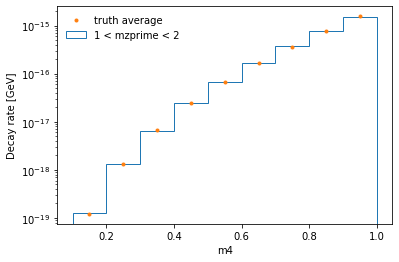

In [125]:
# normal call
output_distrib(df=out, 
               weights=weights['decay rate N'],
               binning_in='m4', #m4 or mzprime
               bins=9, 
               hist_range=[0.1, 1], 
               range_other_variable=[1, 2], 
               type_of_truth='average')

bin size = 0.1
histogram_entries = 9.6e+04
histogram integral = 2.2e-16
Truth = 1.9e-16
Ratio = 0.86


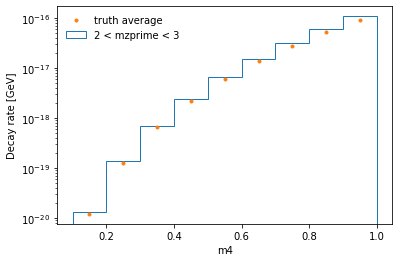

In [32]:
# normal call
output_distrib(df=out, 
               weights=weights['decay rate N'],
               binning_in='m4', #m4 or mzprime
               bins=9, 
               hist_range=[0.1, 1], 
               range_other_variable=[2, 3], 
               type_of_truth='average')

# A new test: sampling only in the physics variables

In [33]:
BSMparams = model.model_params()
     
BSMparams.gprime = np.sqrt(4*np.pi*physics_parameters[case]['alpha_dark'])
BSMparams.chi = np.sqrt(physics_parameters[case]['epsilon2'])/const.cw
BSMparams.Ue4 = 0.0
BSMparams.Umu4 = np.sqrt(physics_parameters[case]['Umu4'])
BSMparams.Utau4 = 0
BSMparams.Ue5 = 0.0
BSMparams.Umu5 = np.sqrt(26.5e-8)
BSMparams.Utau5 = 0
BSMparams.Ue6 = 0.0
BSMparams.Umu6 = np.sqrt(123.0e-8*0.0629)
BSMparams.Utau6 = 0
BSMparams.UD4 = 1
BSMparams.UD5 = 1
BSMparams.UD6 = 1
BSMparams.m4 = 0.5
BSMparams.m5 = 1e6
BSMparams.m6 = 1e6
BSMparams.Mzprime = 5
BSMparams.Dirac = 0

BSMparams.M4_min = physics_parameters[case]['m4_limits'][0]
BSMparams.M4_max = physics_parameters[case]['m4_limits'][1]

BSMparams.mzprime_min = physics_parameters[case]['mz_limits'][0]
BSMparams.mzprime_max = physics_parameters[case]['mz_limits'][1]

BSMparams.set_high_level_variables()

BSMparams.hierarchy = f'{case}_mediator'
BSMparams.scan = False
BSMparams.number_of_scanned_params = 0

myexp = exp.experiment("nd280_nu")

In [34]:
this_MC = MC.MC_events(
                    BSMparams, 
                    myexp, 
                    datafile=None, 
                    MA=1*const.MAVG, 
                    Z=82, 
                    nu_scatterer=pdg.numu,
                    nu_produced=pdg.neutrino4, 
                    nu_outgoing=pdg.numu, 
                    final_lepton=pdg.electron,
                    h_upscattered=-1)

In [35]:
if case == 'heavy':
    DIM = 6
    if BSMparams.scan:
        DIM += BSMparams.number_of_scanned_params

    batch_f = integrands.threebody(dim=DIM, Emin=this_MC.EMIN, Emax=this_MC.EMAX, MC_case=this_MC)

In [36]:
rng = np.random.default_rng()

In [37]:
nsamples = 1000000
random_uniform_numbers = rng.uniform(0, 1, [nsamples, DIM])

In [38]:
weights = batch_f.__call__(random_uniform_numbers)

In [39]:
weights['decay rate N'] = (weights['decay rate N'] / (BSMparams.Mzprime**4 * nsamples))

In [40]:
weights['decay rate N'].sum()

2.1048335154974578e-19

In [41]:
gamma_heavy(BSMparams.m4, BSMparams.Mzprime, physics_parameters[case]['Vmu4_alpha_epsilon2'])

1.959425820060804e-19